In [1]:
# Librairies de calcul
import pandas as pd
import numpy as np
import datetime
# Librairies de visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 


In [2]:
id_client = pd.read_csv ('customers.csv')

id_prod = pd.read_csv ('products.csv')

trans = pd.read_csv ('transactions.csv')

**Pour Rappel :** *Concernant l’analyse de données prévue sous peu, plusieurs aspects doivent être couverts.*
- Besoin de différents indicateurs et graphiques autour du chiffre d'affaires. 
- Regarder l’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale ?
- Faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.
-  quelques informations sur les profils de nos clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.
- Après, toutes les informations et tous graphiques qui apporteraient de l’information pertinente sont les bienvenus !*

## Sommaire <a class="anchor" id="Sommaire"></a>

*[nettoyage des données](#nettoyage)*

[Jointure des dataframes:](#jointure)

[Analyse des différents indicateurs de vente:
Différents indicateurs et graphiques autour du CA dont évolution dans le temps:](#analyse)

[les profils de nos clients](#clients)




## nettoyage des données <a class="anchor" id="nettoyage"></a>

[Sommaire](#Sommaire)

**Dataframe : id_client**

In [3]:
id_client

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


In [4]:
id_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [5]:
# Rechercher d'éventuelles valeurs aberrantes dans la colonne 'client_id' qui ne respectent pas la forme de la clé primaire
valeurs_aberr=id_client[~id_client['client_id'].str.contains("c_")]
valeurs_aberr.head()

,client_id,sex,birth
2735,ct_0,f,2001
8494,ct_1,m,2001


In [6]:
# Suppression des valeurs aberrantes (ct_0 et ct_1) de la colonne 'client_id'
id_client.drop(id_client[id_client['client_id'].str.contains("ct_")].index, inplace=True)

In [7]:
# vérification des valeurs aberrantes (ct_0 et ct_1) supprimées
id_client[id_client['client_id'].str.contains("ct_")]

,client_id,sex,birth


In [8]:
id_client.info()
id_client.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8621 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8621 non-null   object
 1   sex        8621 non-null   object
 2   birth      8621 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 269.4+ KB


,birth
count,8621.000000
mean,1978.275606
std,16.917958
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [9]:
id_client.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

Il n'y a pas de valeurs null dans la dataframe id_client

In [10]:
#vérification s'il existe des doublons id_client
id_client.loc[id_client['client_id'].duplicated(keep= False)]

,client_id,sex,birth


il n'y a pas de doublons

In [11]:
def is_primary_key(df, column_name):
    """
    Vérifie si une colonne donnée est une clé primaire d'un DataFrame donné.
    
    Args:
    - df: DataFrame
    - column_name: str, nom de la colonne à vérifier
    
    Returns:
    - bool, True si la colonne est une clé primaire, False sinon
    """
    # Vérifie si la colonne existe dans le DataFrame
    if column_name not in df.columns:
        raise ValueError(f"La colonne '{column_name}' n'existe pas dans le DataFrame.")
    
    # Vérifie si la colonne a des valeurs uniques
    if df[column_name].nunique() != len(df):
        return False
    
    # Vérifie si la colonne n'a pas de valeurs manquantes
    if df[column_name].isnull().any():
        return False
    
    # Si toutes les conditions sont remplies, la colonne est une clé primaire
    return True

In [12]:
print(is_primary_key(id_client, "client_id"))

True


**dataframe : id_prod**

In [13]:
id_prod

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


In [14]:
id_prod.info()
id_prod.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [15]:
id_prod.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [16]:
#vérification s'il existe des doublons id_prod
id_prod.loc[id_prod['id_prod'].duplicated(keep= False)]

,id_prod,price,categ


il n'y a pas de doublons

In [17]:
print(is_primary_key(id_prod, "id_prod"))

True


**Dataframe : Trans** (transaction)

In [18]:
trans

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232
...,...,...,...,...
679527,0_1551,2022-01-15 13:05:06.246925,s_150195,c_8489
679528,1_639,2022-03-19 16:03:23.429229,s_181434,c_4370
679529,0_1425,2022-12-20 04:33:37.584749,s_314704,c_304
679530,0_1994,2021-07-16 20:36:35.350579,s_63204,c_2227


In [19]:
trans.info()
trans.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


Nous pouvons remarquer dans le top une date test , il va nous falloir vérifier qu'il y en n'ai pas d'autres et ensuite les effacer pour poursuivre l'analyse

In [20]:
#isolation des sessions test
trans_test= trans[trans['session_id'] == 's_0']
trans_test

,id_prod,date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


In [21]:
# Suppression du produit test:
trans.drop(trans[(trans["session_id"] == "s_0")].index, inplace=True)

In [22]:
# Suppression des valeurs aberrantes (test) de la colonne 'date'
#trans.drop(trans[trans['date'].str.contains("test")].index,inplace=True)

In [23]:
trans.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [24]:
trans.describe()

,id_prod,date,session_id,client_id
count,679332,679332,679332,679332
unique,3266,679332,342315,8600
top,1_369,2022-05-20 13:21:29.043970,s_118668,c_1609
freq,2252,1,14,25488


les produits test ont bien été supprimés

In [25]:
trans.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

**Jointure des dataframes:** <a class="anchor" id="jointure"></a>

[Sommaire](#Sommaire)

les références sont à l'extérieur de la dataframe transaction il est important ici de faire les deux jointures en outer afin de pouvoir relier l'ensemble des dataframes

In [26]:
interm_df =  pd.merge(trans, id_client, on = ["client_id"], how = "outer", indicator = True)

In [27]:
interm_df.isnull().sum()

id_prod       21
date          21
session_id    21
client_id      0
sex            0
birth          0
_merge         0
dtype: int64

In [28]:
interm_df['_merge'].unique()

['both', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']

In [29]:
interm_df[interm_df['_merge'] == 'right_only']

,id_prod,date,session_id,client_id,sex,birth,_merge
679332,NaN,NaN,NaN,c_8253,f,2001,right_only
679333,NaN,NaN,NaN,c_3789,f,1997,right_only
679334,NaN,NaN,NaN,c_4406,f,1998,right_only
679335,NaN,NaN,NaN,c_2706,f,1967,right_only
679336,NaN,NaN,NaN,c_3443,m,1959,right_only
679337,NaN,NaN,NaN,c_4447,m,1956,right_only
679338,NaN,NaN,NaN,c_3017,f,1992,right_only
679339,NaN,NaN,NaN,c_4086,f,1992,right_only
679340,NaN,NaN,NaN,c_6930,m,2004,right_only
679341,NaN,NaN,NaN,c_4358,m,1999,right_only


Liste des 21 clients qui n'ont fait aucun achat en ligne

In [30]:
#Isolation des clients qui n'ont fait aucun achat
interm_df_right_only = interm_df[interm_df['_merge'] == 'right_only']

In [31]:
interm_df =interm_df.dropna(subset = ['id_prod'])

In [32]:
interm_df.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
sex           0
birth         0
_merge        0
dtype: int64

In [33]:
interm_df =  pd.merge(trans, id_client, on = ["client_id"], how = "inner")

In [34]:
interm_df.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
sex           0
birth         0
dtype: int64

In [35]:
complet_df =  pd.merge(interm_df, id_prod, on = ["id_prod"], how = "outer", indicator = True)

In [36]:
complet_df.isna().sum()

id_prod         0
date           22
session_id     22
client_id      22
sex            22
birth          22
price         221
categ         221
_merge          0
dtype: int64

In [37]:
complet_df['_merge'].unique()

['both', 'left_only', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']

In [38]:
Complet_df_right= complet_df[complet_df['_merge'] == 'right_only']
Complet_df_right

,id_prod,date,session_id,client_id,sex,birth,price,categ,_merge
679332,0_1016,NaN,NaN,NaN,NaN,NaN,35.06,0.0,right_only
679333,0_1780,NaN,NaN,NaN,NaN,NaN,1.67,0.0,right_only
679334,T_0,NaN,NaN,NaN,NaN,NaN,-1.00,0.0,right_only
679335,0_1062,NaN,NaN,NaN,NaN,NaN,20.08,0.0,right_only
679336,0_1119,NaN,NaN,NaN,NaN,NaN,2.99,0.0,right_only
679337,0_1014,NaN,NaN,NaN,NaN,NaN,1.15,0.0,right_only
679338,1_0,NaN,NaN,NaN,NaN,NaN,31.82,1.0,right_only
679339,0_1318,NaN,NaN,NaN,NaN,NaN,20.92,0.0,right_only
679340,0_1800,NaN,NaN,NaN,NaN,NaN,22.05,0.0,right_only
679341,0_1645,NaN,NaN,NaN,NaN,NaN,2.99,0.0,right_only


In [39]:
Complet_df_left = complet_df[complet_df['_merge'] == 'left_only']
Complet_df_left

,id_prod,date,session_id,client_id,sex,birth,price,categ,_merge
311747,0_2245,2021-04-22 04:57:20.090378,s_23987,c_6714,f,1968.0,NaN,NaN,left_only
311748,0_2245,2021-06-05 17:04:43.982913,s_44481,c_6714,f,1968.0,NaN,NaN,left_only
311749,0_2245,2022-04-05 17:04:43.982913,s_189669,c_6714,f,1968.0,NaN,NaN,left_only
311750,0_2245,2022-05-05 17:04:43.982913,s_204093,c_6714,f,1968.0,NaN,NaN,left_only
311751,0_2245,2022-12-05 17:04:43.982913,s_307520,c_6714,f,1968.0,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...
311963,0_2245,2021-10-19 09:32:03.667461,s_107022,c_6128,m,1986.0,NaN,NaN,left_only
311964,0_2245,2021-11-12 09:25:22.905886,s_118458,c_7416,m,1933.0,NaN,NaN,left_only
311965,0_2245,2021-08-22 08:51:27.564509,s_79102,c_6752,m,1987.0,NaN,NaN,left_only
311966,0_2245,2022-04-22 08:51:27.564509,s_197669,c_6752,m,1987.0,NaN,NaN,left_only


il y a beaucoup de nan ce qui s'explique par la différence entre les dataframe id_client et id_prod


On a également 22 produits qui ne se sont jamais vendus mais qui sont présents dans notre référencement.

Par contre nous avons 221 price et categ manquant ce qui peut poser problème dans l'analyse

In [40]:
# Creation d'une dataframe que sur les ventes effectués que nous appelerons Ventes_df:
ventes_df = complet_df.dropna()
ventes_df.info()
ventes_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679331
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   id_prod     679111 non-null  object  
 1   date        679111 non-null  object  
 2   session_id  679111 non-null  object  
 3   client_id   679111 non-null  object  
 4   sex         679111 non-null  object  
 5   birth       679111 non-null  float64 
 6   price       679111 non-null  float64 
 7   categ       679111 non-null  float64 
 8   _merge      679111 non-null  category
dtypes: category(1), float64(3), object(5)
memory usage: 47.3+ MB


id_prod       0
date          0
session_id    0
client_id     0
sex           0
birth         0
price         0
categ         0
_merge        0
dtype: int64

In [41]:
ventes_df

,id_prod,date,session_id,client_id,sex,birth,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986.0,4.18,0.0,both
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986.0,4.18,0.0,both
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986.0,4.18,0.0,both
3,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,f,1968.0,4.18,0.0,both
4,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,f,1968.0,4.18,0.0,both
...,...,...,...,...,...,...,...,...,...
679327,1_408,2023-01-26 06:52:02.225335,s_332548,c_7402,m,1945.0,35.24,1.0,both
679328,1_408,2022-11-26 06:52:02.225335,s_302962,c_7402,m,1945.0,35.24,1.0,both
679329,1_408,2021-09-26 06:52:02.225335,s_95708,c_7402,m,1945.0,35.24,1.0,both
679330,2_81,2022-02-19 14:51:58.078656,s_167662,c_7616,m,1993.0,86.99,2.0,both


In [42]:
ventes_df['date'] = pd.to_datetime(ventes_df['date'])

C:\Users\x muscador x\AppData\Local\Temp\ipykernel_2780\609781186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventes_df['date'] = pd.to_datetime(ventes_df['date'])


In [43]:
# Facilite la manipulation des dates:
ventes_df["year"] = ventes_df["date"].dt.year
ventes_df["month"] = ventes_df["date"].dt.month
ventes_df["day"] = ventes_df["date"].dt.day

C:\Users\x muscador x\AppData\Local\Temp\ipykernel_2780\2898332475.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventes_df["year"] = ventes_df["date"].dt.year
C:\Users\x muscador x\AppData\Local\Temp\ipykernel_2780\2898332475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventes_df["month"] = ventes_df["date"].dt.month
C:\Users\x muscador x\AppData\Local\Temp\ipykernel_2780\2898332475.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [44]:
ventes_df

,id_prod,date,session_id,client_id,sex,birth,price,categ,_merge,year,month,day
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986.0,4.18,0.0,both,2022,5,20
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986.0,4.18,0.0,both,2021,7,20
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986.0,4.18,0.0,both,2022,8,20
3,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,f,1968.0,4.18,0.0,both,2021,5,9
4,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,f,1968.0,4.18,0.0,both,2022,5,30
...,...,...,...,...,...,...,...,...,...,...,...,...
679327,1_408,2023-01-26 06:52:02.225335,s_332548,c_7402,m,1945.0,35.24,1.0,both,2023,1,26
679328,1_408,2022-11-26 06:52:02.225335,s_302962,c_7402,m,1945.0,35.24,1.0,both,2022,11,26
679329,1_408,2021-09-26 06:52:02.225335,s_95708,c_7402,m,1945.0,35.24,1.0,both,2021,9,26
679330,2_81,2022-02-19 14:51:58.078656,s_167662,c_7616,m,1993.0,86.99,2.0,both,2022,2,19


In [45]:
# Ajout d'une colonne "age" aux clients
from datetime import datetime


ventes_df["age"] = ventes_df["year"] - ventes_df["birth"]

C:\Users\x muscador x\AppData\Local\Temp\ipykernel_2780\1878658264.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ventes_df["age"] = ventes_df["year"] - ventes_df["birth"]


In [46]:
ventes_df

,id_prod,date,session_id,client_id,sex,birth,price,categ,_merge,year,month,day,age
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986.0,4.18,0.0,both,2022,5,20,36.0
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986.0,4.18,0.0,both,2021,7,20,35.0
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986.0,4.18,0.0,both,2022,8,20,36.0
3,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,f,1968.0,4.18,0.0,both,2021,5,9,53.0
4,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,f,1968.0,4.18,0.0,both,2022,5,30,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
679327,1_408,2023-01-26 06:52:02.225335,s_332548,c_7402,m,1945.0,35.24,1.0,both,2023,1,26,78.0
679328,1_408,2022-11-26 06:52:02.225335,s_302962,c_7402,m,1945.0,35.24,1.0,both,2022,11,26,77.0
679329,1_408,2021-09-26 06:52:02.225335,s_95708,c_7402,m,1945.0,35.24,1.0,both,2021,9,26,76.0
679330,2_81,2022-02-19 14:51:58.078656,s_167662,c_7616,m,1993.0,86.99,2.0,both,2022,2,19,29.0


**Analyse des différents indicateurs de vente:
Différents indicateurs et graphiques autour du CA dont évolution dans le temps:** <a class="anchor" id="analyse"></a>

[Sommaire](#Sommaire)

In [47]:
# CA total:
ca_tot = complet_df.loc[(complet_df["client_id"] != "NaN"),"price"].sum()
ventes_tot = ventes_df["session_id"].count()

print("Le chiffre d'affaires total est de", ca_tot, "€")
print("pour un total de", ventes_tot, "ventes.")

Le chiffre d'affaires total est de 11854522.96 €
pour un total de 679111 ventes.


In [48]:
#panier moyen = ca/nbre de commandes
panier_moyen = ca_tot/ventes_tot

print("le panier moyen est de" , panier_moyen)

le panier moyen est de 17.45594307852472


In [49]:
# CA annuel:
ca_annuel = ventes_df.groupby(["year"])["price"].sum()
print("Chiffres d'affaires annuels\n:", ca_annuel)

# Nombre de ventes annuel:
ventes_annuelles = ventes_df.groupby(["year"])["session_id"].count()
print("Nombre de ventes annuelles:\n", ventes_annuelles)

Chiffres d'affaires annuels
: year
2021    4770826.56
2022    6108681.81
2023     974220.31
Name: price, dtype: float64
Nombre de ventes annuelles:
 year
2021    278248
2022    346380
2023     54483
Name: session_id, dtype: int64


In [50]:
ventes_2023 = ventes_df[ventes_df['year'] == 2023] 


In [51]:
ventes_2023.describe()

,birth,price,categ,year,month,day,age
count,54483.000000,54483.000000,54483.000000,54483.0,54483.000000,54483.000000,54483.000000
mean,1977.839656,17.881180,0.463980,2023.0,1.468862,15.397739,45.160344
std,13.804974,19.059602,0.602664,0.0,0.499034,8.538321,13.804974
min,1929.000000,0.660000,0.000000,2023.0,1.000000,1.000000,19.000000
25%,1970.000000,8.990000,0.000000,2023.0,1.000000,8.000000,36.000000
50%,1980.000000,13.990000,0.000000,2023.0,1.000000,15.000000,43.000000
75%,1987.000000,19.440000,1.000000,2023.0,2.000000,23.000000,53.000000
max,2004.000000,247.220000,2.000000,2023.0,2.000000,31.000000,94.000000


2022 est notre meilleure année concernant le chiffre d'affaires et du nombre de ventes jusqu'à présent, cependant les données de 2023 ne sont pas complètes s'arretant au mois de février. Il faudrait donc comparer mensuellement plutôt pour voir si la situation en février 2023 est meilleure que les années précédentes pour la même période. 

In [52]:
ventes_df['date'].nlargest(1)

356690   2023-02-28 23:58:30.792755
Name: date, dtype: datetime64[ns]

la dernière vente en 2023 est réalisée le 28 février à 23h58

In [53]:
# CA mensuel:
ventes_df = ventes_df.sort_values(["date"],ascending=True)
ca_mensu = ventes_df.groupby(["year","month"])["price"].sum()

Text(0.5, 1.0, "Evolution mensuelle du chiffre d'affaires")

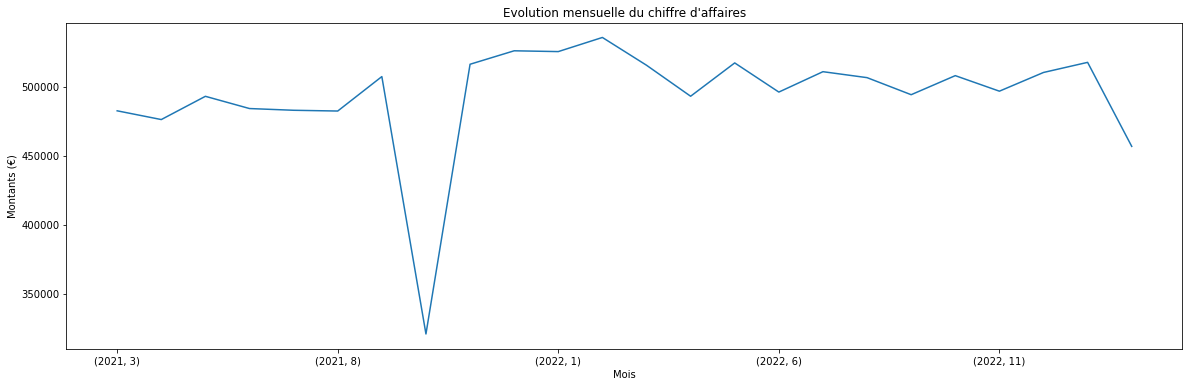

In [54]:
# Nombre de ventes mensuelles:
ventes_mensu = ventes_df.groupby(["year", "month"])["session_id"].count()

# Graphique:
plt.figure(figsize = (20,6))
ca_mensu.plot()
plt.xlabel("Mois")
plt.ylabel("Montants (€)")
plt.title("Evolution mensuelle du chiffre d'affaires")

Text(0.5, 1.0, "Evolution journalier du chiffre d'affaires")

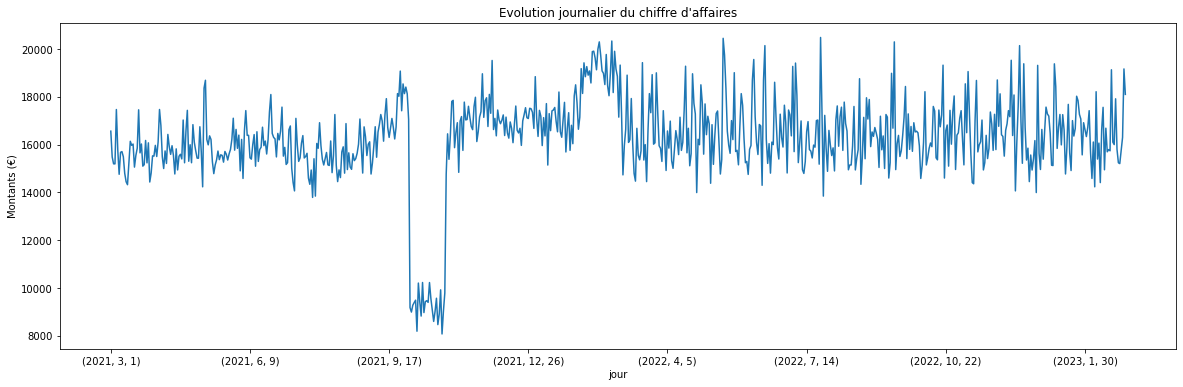

In [55]:
# CA journalier:
ventes_df = ventes_df.sort_values(["date"],ascending=True)
ca_journalier = ventes_df.groupby(["year","month","day"])["price"].sum()
# Nombre de ventes mensuelles:
ventes_mensu = ventes_df.groupby(["year", "day"])["session_id"].count()

# Graphique:
plt.figure(figsize = (20,6))
ca_journalier.plot()
plt.xlabel("jour")
plt.ylabel("Montants (€)")
plt.title("Evolution journalier du chiffre d'affaires")

year  month  day
2021  3      1               NaN
             2               NaN
             3               NaN
             4               NaN
             5               NaN
                        ...     
2023  2      24     16488.778571
             25     16006.747143
             26     16035.021429
             27     16487.570000
             28     16513.984286
Name: price, Length: 730, dtype: float64


Text(0.5, 1.0, "Moyenne mobile du chiffre d'affaire")

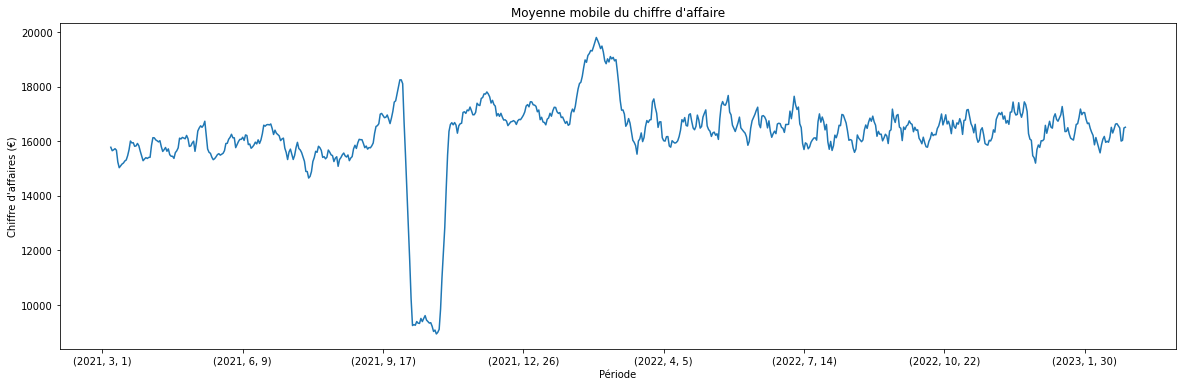

In [56]:
# Decomposition en moyenne mobile:
moyenne_mob = ca_journalier.rolling(7).mean()
print(moyenne_mob)

# Graphique:
plt.figure(figsize = (20,6))
moyenne_mob.plot()
plt.xlabel("Période")
plt.ylabel("Chiffre d'affaires (€)")
plt.title("Moyenne mobile du chiffre d'affaire")

 l’intervalle de la fenêtre de temps est de 7, il y a six valeurs nan au départ car la moyenne mobile n’a pas pu être calculée pour elles.

La moyenne mobile est fréquemment utilisée pour étudier les données de séries chronologiques en calculant la moyenne des données à des intervalles spécifiques. Il est utilisé pour lisser certaines fluctuations à court terme et étudier les tendances des données.

Nombre de ventes par catégories:
 categ
0.0    415459
1.0    227169
2.0     36483
Name: session_id, dtype: int64
Prix moyen d'un livre selon sa catégorie:
 categ
0.0    10.638188
1.0    20.485730
2.0    76.207412
Name: price, dtype: float64
Chiffre d'affaires par catégorie
 categ
0.0    4419730.97
1.0    4653722.69
2.0    2780275.02
Name: price, dtype: float64


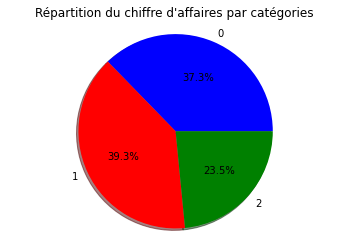

In [57]:

# Volume de ventes par categories:
vol_categ = ventes_df.groupby(["categ"])["session_id"].count()

print("Nombre de ventes par catégories:\n", vol_categ)

# Prix moyen par categories:
prix_categ = ventes_df.groupby(["categ"])["price"].mean()
print("Prix moyen d'un livre selon sa catégorie:\n",prix_categ)

# CA par categories:
ca_categ = ventes_df.groupby(ventes_df["categ"])["price"].sum()
print("Chiffre d'affaires par catégorie\n",ca_categ)

# Graphique:
fig1, ax1 = plt.subplots()
ax1.pie(ca_categ,
        labels=["0","1","2"],
        autopct="%1.1f%%",
        colors=['blue', 'red', 'green'],
        shadow=True)
ax1.axis("equal")
plt.title("Répartition du chiffre d'affaires par catégories")
plt.show()


Nous vendons plus de livre de catégorie 0 mais c'est les livres de catégorie 1 qui nous rapporte plus avec une représentation du chiffre d'affaires à 39.3% sur l'ensemble des années.

In [58]:
# Meilleures et pires ventes:
nbr_ventes_ref = ventes_df.groupby(["id_prod"])["session_id"].count()

print("Références les plus vendues")
print(nbr_ventes_ref.nlargest(10))
print("Références les moins vendues")
print(nbr_ventes_ref.nsmallest(10))

Références les plus vendues
id_prod
1_369    2252
1_417    2189
1_414    2180
1_498    2128
1_425    2096
1_403    1960
1_412    1951
1_413    1945
1_406    1939
1_407    1935
Name: session_id, dtype: int64
Références les moins vendues
id_prod
0_1151    1
0_1284    1
0_1379    1
0_1498    1
0_1539    1
0_1601    1
0_1633    1
0_1683    1
0_1728    1
0_2201    1
Name: session_id, dtype: int64


les 3 références les plus vendues sont 1_369 , 1_417, 1_414

 **les profils de nos clients** <a class="anchor" id="clients"></a>

[Sommaire](#Sommaire)

In [59]:
# Nombre moyen d'achats par sessions:
print("Il y a eu",
      complet_df["session_id"].nunique(),
      "sessions mais", ventes_df["session_id"].nunique(), "ont terminé en ventes")

print("Une session aboutie en moyenne à",
      round(complet_df.groupby(["session_id","client_id"])["id_prod"].count().mean(),2),
      "achats")

Il y a eu 342315 sessions mais 342275 ont terminé en ventes
Une session aboutie en moyenne à 1.98 achats


In [60]:
# Meilleurs clients:
best_client = ventes_df.groupby(["client_id"])["price"].sum()

print("Clients ayant le plus dépensé")
print(best_client.nlargest(10))

Clients ayant le plus dépensé
client_id
c_1609    324033.35
c_4958    289760.34
c_6714    153598.92
c_3454    113637.93
c_3263      5276.87
c_1570      5271.62
c_2899      5214.05
c_2140      5208.82
c_7319      5155.77
c_7959      5085.45
Name: price, dtype: float64


In [61]:
#id_client_ab = id_client[id_client['client_id'] == ('c_1609' , 'c_4958', 'c_6714', 'c_3454')]
id_client_ab = id_client[id_client['client_id'] == ('c_3454' , 'c_1609' , 'c_4958', 'c_6714' )] 
id_client_ab

,client_id,sex,birth


Nous pouvons remarquer pour les 4 premiers ont un gros volume de ventes peut-être des institutions ou des revendeurs. Nous pouvons les exclures pour la suite de l'analyse ou les réintégrer si on souhaite les inclures dans l'analyse

indice de Gini: 0.447


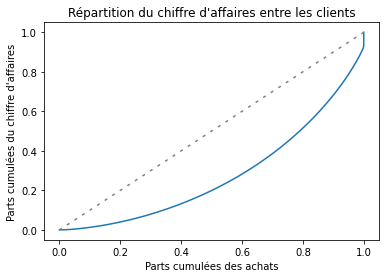

In [62]:
# Courbe de Lorentz: (repartition du CA par clients)
lorenz_CA_client = np.cumsum(np.sort(best_client)) / best_client.sum()
lorenz_CA_client = np.append([0], lorenz_CA_client)
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), lorenz_CA_client, drawstyle="steps-post")
plt.plot(np.linspace(0,1,len(lorenz_CA_client)), np.linspace(0,1,len(lorenz_CA_client)), color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des achats")
plt.title("Répartition du chiffre d'affaires entre les clients")
aire_ss_courbe_CA_client = lorenz_CA_client[:-1].sum() / len(lorenz_CA_client)
S_ca_client = 0.5 - aire_ss_courbe_CA_client
gini_CA_client = 2*S_ca_client
print("indice de Gini:",round(gini_CA_client,3))

la courbe de lorenz nous relève bien qu'il y a une répartition inégale sur l'ensemble , nous allons exclure les 4 gros achats afin de voir la répartition du chiffre d'affaires entre les clients

In [63]:
ventes_df_2 = ventes_df
ventes_df_2.drop(ventes_df_2[(ventes_df_2["client_id"] == "c_1609")].index, inplace = True)
ventes_df_2.drop(ventes_df_2[(ventes_df_2["client_id"] == "c_3454")].index, inplace=True)
ventes_df_2.drop(ventes_df_2[(ventes_df_2["client_id"] == "c_4958")].index, inplace=True)
ventes_df_2.drop(ventes_df_2[(ventes_df_2["client_id"] == "c_6714")].index, inplace=True)

In [64]:
best_client_2 = ventes_df_2.groupby(["client_id"])["price"].sum()

print("Clients ayant le plus dépensé")
print(best_client_2.nlargest(10))

Clients ayant le plus dépensé
client_id
c_3263    5276.87
c_1570    5271.62
c_2899    5214.05
c_2140    5208.82
c_7319    5155.77
c_7959    5085.45
c_8026    5082.58
c_7421    5050.20
c_5263    5006.85
c_1422    4993.55
Name: price, dtype: float64


indice de Gini: 0.403


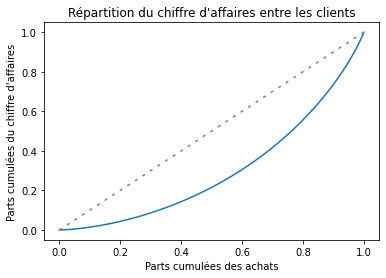

In [65]:
# Courbe de Lorentz: (repartition du CA par clients)
lorenz_CA_client_2 = np.cumsum(np.sort(best_client_2)) / best_client_2.sum()
lorenz_CA_client_2 = np.append([0], lorenz_CA_client_2)
plt.plot(np.linspace(0,1,len(lorenz_CA_client_2)), lorenz_CA_client_2, drawstyle="steps-post")
plt.plot(np.linspace(0,1,len(lorenz_CA_client_2)), np.linspace(0,1,len(lorenz_CA_client_2)), color ="grey", dashes=[2,4])
plt.ylabel("Parts cumulées du chiffre d'affaires")
plt.xlabel("Parts cumulées des achats")
plt.title("Répartition du chiffre d'affaires entre les clients")
aire_ss_courbe_CA_client_2 = lorenz_CA_client_2[:-1].sum() / len(lorenz_CA_client_2)
S_ca_client_2 = 0.5 - aire_ss_courbe_CA_client_2
gini_CA_client_2 = 2*S_ca_client_2
print("indice de Gini:",round(gini_CA_client_2,3))

l'indice de Gini nous révèle la répartion équilibré du chiffre d'affaires entre les clients contrairement à la première courbe qui nous indiquer une répartition inégale entre les institutions ( ou revendeurs) dû a leur chiffre d'affaire aberrants

sex
f    4490
m    4131
Name: client_id, dtype: int64


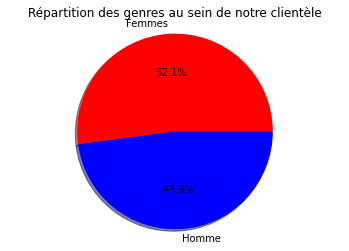

In [66]:
# Repartition des genres parmis nos clients:
repartition_genre = id_client.groupby(["sex"])["client_id"].count()
print(repartition_genre)

# Graphique:
fig2, ax2 = plt.subplots()
ax2.pie(repartition_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["red","blue"],
        shadow=True)
ax2.axis("equal")
plt.title("Répartition des genres au sein de notre clientèle")
plt.show()

Notre clientèle est composé de 52.1% de femmes et 47.9% d'hommes

montant total des achats par genre:
 sex
f    5706084.21
m    5266613.93
Name: price, dtype: float64
nombre total d'achats par genre:
 sex
f    329104
m    303373
Name: price, dtype: int64
montant moyen des achats par genre:
 sex
f    17.338240
m    17.360193
Name: price, dtype: float64


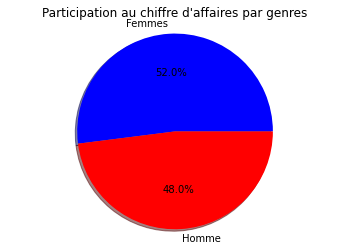

In [67]:
# Depenses par genres :
repartition_achats_genre = ventes_df_2.groupby(["sex"])["price"].sum()
print("montant total des achats par genre:\n", repartition_achats_genre)

nbr_achats_genre = ventes_df_2.groupby(["sex"])["price"].count()
print("nombre total d'achats par genre:\n", nbr_achats_genre)

moy_achats_genre = ventes_df_2.groupby(["sex"])["price"].mean()
print("montant moyen des achats par genre:\n", moy_achats_genre)


# Graphique:
fig3, ax3 = plt.subplots()
ax3.pie(repartition_achats_genre,
        labels=["Femmes","Homme"],
        autopct="%1.1f%%",
        colors=["blue","red"],
        shadow=True)
ax3.axis("equal")
plt.title("Participation au chiffre d'affaires par genres")
plt.show()

Pour rappel les 4 gros acheteurs ont été exclus de l'analyse mais présent dans la dataframe ventes_df

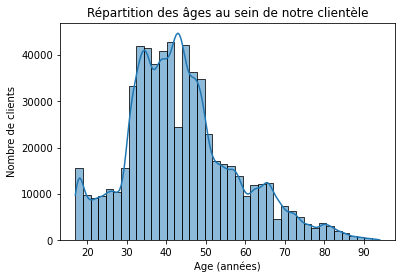

In [68]:
# Repartition des ages parmis nos clients:
sns.histplot(data=ventes_df_2["age"],
             bins=40,
             kde=True)
plt.title("Répartition des âges au sein de notre clientèle")
plt.ylabel("Nombre de clients")
plt.xlabel("Age (années)")
plt.show()

comme on peut le voir il y a une forte concentration de notre clientèle pour la tranche d'age de 30-50 ans 

In [69]:
# Ajout des tranches d'ages:
ventes_df_2["age_range"] = pd.cut(x= ventes_df_2["age"], bins=[0,25,50,75,100], include_lowest=False, ordered=True)

# Repartition des achats par tranches d'ages:
repartition_achats_age_range = ventes_df_2.groupby(["age_range"])["price"].sum()
print("montant total des achats par tranches d'age:\n", repartition_achats_age_range)

# Nombre d'achats par tranches d'ages:
nbr_achats_age_range = ventes_df_2.groupby(["age_range"])["price"].count()
print("nombre total d'achats par tranches d'age:\n",nbr_achats_age_range)

# Motant moyen des achats par tranches d'ages:
moy_achats_age_range = ventes_df_2.groupby(["age_range"])["price"].mean()
print("montant moyen des achats par tranches d'age:\n", moy_achats_age_range)

montant total des achats par tranches d'age:
 age_range
(0, 25]      1990501.26
(25, 50]     6272191.27
(50, 75]     2422527.40
(75, 100]     287478.21
Name: price, dtype: float64
nombre total d'achats par tranches d'age:
 age_range
(0, 25]       49473
(25, 50]     421171
(50, 75]     144777
(75, 100]     17056
Name: price, dtype: int64
montant moyen des achats par tranches d'age:
 age_range
(0, 25]      40.234093
(25, 50]     14.892268
(50, 75]     16.732819
(75, 100]    16.854961
Name: price, dtype: float64


les 0-25 ans ont le montant moyen des achats le plus élevé , mais c'est les 25-50 ans qui dépense le plus pour un montant total de 6272191 et constitue par la même occasion le nombre total d'achats le plus élevé avec 421171 sur l'ensemble des années étudier. Il serait intéressant de cibler pour les prochaines campagnes marketing les moins de 25 ans afin d'en augmenter le nombre parmi notre clientèle, car le montant moyen des achats pour les moins de 25 ans est de 40.23.

In [70]:
ventes_df_2

,id_prod,date,session_id,client_id,sex,birth,price,categ,_merge,year,month,day,age,age_range
191139,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,f,1967.0,11.99,0.0,both,2021,3,1,54.0,"(50, 75]"
2269,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,m,1960.0,19.37,0.0,both,2021,3,1,61.0,"(50, 75]"
441509,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,m,1988.0,4.50,0.0,both,2021,3,1,33.0,"(25, 50]"
446670,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,f,1989.0,6.55,0.0,both,2021,3,1,32.0,"(25, 50]"
67108,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,f,1956.0,16.49,0.0,both,2021,3,1,65.0,"(50, 75]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510204,1_508,2023-02-28 23:49:03.148402,s_348444,c_3573,f,1996.0,21.92,1.0,both,2023,2,28,27.0,"(25, 50]"
271337,2_37,2023-02-28 23:51:29.318531,s_348445,c_50,f,1994.0,48.99,2.0,both,2023,2,28,29.0,"(25, 50]"
225071,1_695,2023-02-28 23:53:18.929676,s_348446,c_488,f,1985.0,26.99,1.0,both,2023,2,28,38.0,"(25, 50]"
3230,0_1547,2023-02-28 23:58:00.107815,s_348447,c_4848,m,1953.0,8.99,0.0,both,2023,2,28,70.0,"(50, 75]"


Text(0.5, 1.0, 'Motant des achats par âges')

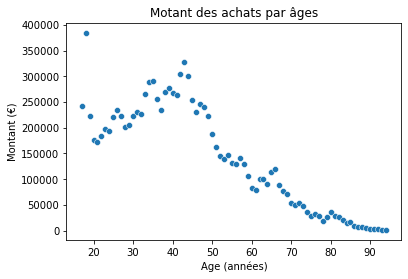

In [71]:
# Lien entre l'age et le montant des achats:
age = ventes_df_2.groupby(["age"])["client_id"].count()
tot_achats_age = ventes_df_2.groupby(["age"])["price"].sum()


# Graphique:
sns.scatterplot(data= tot_achats_age)
plt.ylabel("Montant (€)")
plt.xlabel("Age (années)")
plt.title("Motant des achats par âges")

Nous pouvons remarquer un outliers pour les 18 ans . 

Text(0.5, 1.0, "Nombre d'achats selon l'âge")

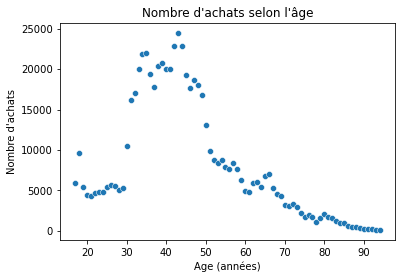

In [72]:
# Lien entre l'age et la taille du panier:
nbr_achats_age = ventes_df_2.groupby(["age"])["session_id"].count()

# Graphique:
sns.scatterplot(data= nbr_achats_age)
plt.ylabel("Nombre d'achats")
plt.xlabel("Age (années)")
plt.title("Nombre d'achats selon l'âge")

In [73]:
#hypothèse de linéarité - test de normalité Shapiro
from scipy import stats
rng = np.random.default_rng()
x = stats.norm.rvs(loc=5, scale=3, size=100, random_state=rng)
shapiro_test = stats.shapiro(x)
shapiro_test


ShapiroResult(statistic=0.979759156703949, pvalue=0.12731388211250305)

la p-value est supérieure au niveau alpha choisi (0.05), alors on ne doit pas rejeter l'hypothèse nulle. La valeur de la p-value alors obtenue ne présuppose en rien de la nature de la distribution des données.

**ANOVA**

In [74]:
ventes_df_2.columns

Index(['id_prod', 'date', 'session_id', 'client_id', 'sex', 'birth', 'price',
       'categ', '_merge', 'year', 'month', 'day', 'age', 'age_range'],
      dtype='object')

In [75]:
X = "categ" # qualitative
Y = "age" # quantitative

# On ne garde que les dépenses
sous_echantillon = ventes_df_2[ventes_df_2["age"]>10].copy()
# On remet les dépenses en positif
#sous_echantillon["age"] = -sous_echantillon["age"]
# On n'étudie pas les loyers car trop gros:
#sous_echantillon = sous_echantillon[sous_echantillon["categ"] != "LOYER"] 

In [76]:
sous_echantillon[X].unique()

array([0., 1., 2.])

In [77]:
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])



In [78]:
X = "categ" # qualitative
Y = "age" # quantitative

sous_echantillon = ventes_df_2.copy() # On ne garde que les dépenses

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print(eta_squared(sous_echantillon[X],sous_echantillon[Y]))

0.11333046867894486


eta_squared est égale à 0.11 ce qui nous montre qu'il y a une corrélation entre les deux variables

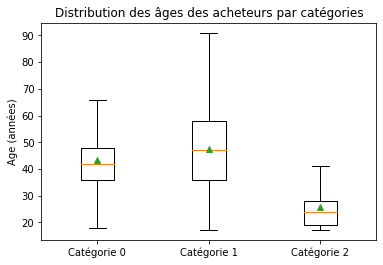

In [79]:
# Categories les plus achetees par age:

categ = ventes_df_2["categ"].unique()
categ_age = {categ: ventes_df_2.loc[ventes_df_2["categ"]==categ, "age"] for categ in categ}

# Graphique:
plt.boxplot([
    categ_age[0],
    categ_age[1],
    categ_age[2]]
    ,labels=["Catégorie 0", "Catégorie 1", "Catégorie 2"],showmeans=True, showfliers=False)
plt.ylabel("Age (années)")
plt.title("Distribution des âges des acheteurs par catégories")
plt.show()


In [80]:
ventes_df_2.head()


,id_prod,date,session_id,client_id,sex,birth,price,categ,_merge,year,month,day,age,age_range
191139,0_1259,2021-03-01 00:01:07.843138,s_1,c_329,f,1967.0,11.99,0.0,both,2021,3,1,54.0,"(50, 75]"
2269,0_1390,2021-03-01 00:02:26.047414,s_2,c_664,m,1960.0,19.37,0.0,both,2021,3,1,61.0,"(50, 75]"
441509,0_1352,2021-03-01 00:02:38.311413,s_3,c_580,m,1988.0,4.50,0.0,both,2021,3,1,33.0,"(25, 50]"
446670,0_1458,2021-03-01 00:04:54.559692,s_4,c_7912,f,1989.0,6.55,0.0,both,2021,3,1,32.0,"(25, 50]"
67108,0_1358,2021-03-01 00:05:18.801198,s_5,c_2033,f,1956.0,16.49,0.0,both,2021,3,1,65.0,"(50, 75]"


In [81]:
import scipy.stats as st
import numpy as np
#le coefficient de Pearson et la covariance
print(st.pearsonr(ventes_df_2["age"],-ventes_df_2["price"])[0])
print(np.cov(ventes_df_2["age"],-ventes_df_2["price"],ddof=0)[1,0])

0.1968365511305894
49.382275660187986



Rappel : Si le coefficient de corrélation de Pearson est proche de 1, cela indique une forte corrélation positive, ce qui signifie que les deux variables augmentent ou diminuent ensemble. Elle est de 0.19 ce qui veut dire qu'il y a une faible corrélation entre l'age et le prix

Si la covariance est positive, cela signifie que les deux variables ont tendance à augmenter ou diminuer ensemble. 


In [82]:
#le tableau de contingence
X = "sex"
Y = "categ"

cont = ventes_df_2[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

categ,0.0,1.0,2.0,Total
sex,,,,
f,200793,111331,16980,329104
m,186488,101017,15868,303373
Total,387281,212348,32848,632477


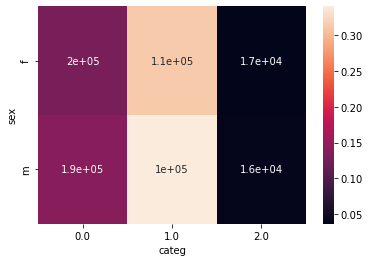

In [83]:
import seaborn as sns

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(ventes_df_2)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()


In [84]:
print(xi_n)

20.2134606935139


chi2 est égal à 20.21 

 l'hypothèse nulle est rejetée, les catégories des livres achetées ne dépendent donc pas du genre de l'acheteur.